In [1]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Loading data into Pandas DataFrame

In [2]:
red_df = pd.read_csv('winequality-red.csv', sep=';')

In [3]:
#splits dataset into features and wine score dataframes
df_features = red_df.drop(columns='quality')
df_score = red_df['quality']

#list of scores given to wines (for labels)
score = ['3','4', '5', '6', '7', '8']

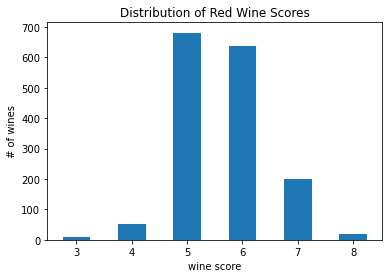

In [4]:
plt.hist(red_df['quality'], bins=[3,4,5,6,7,8,9], align='left', rwidth=0.5)
plt.title('Distribution of Red Wine Scores')
plt.xlabel('wine score')
plt.ylabel('# of wines')
#plt.savefig('red_score_hist.png')
plt.show()

## Scaling Data

In [5]:
#Scales features by subtracting the mean and dividing by the standard deviation [z=(x-u)/s]
df_features_scaled = StandardScaler().fit_transform(df_features)

## Splitting into Training and Test Data

In [6]:
#Splitting into train/test set (default=75/25)
X_train, X_test, y_train, y_test = train_test_split(df_features_scaled, df_score, test_size=0.33)

## Model Tuning

In [7]:
#Dictionary of paramaters that will be tested
param_grid = {
    'n_estimators': [100, 120, 140, 200],
    'max_depth': [3, 5, 8, 10, 12],
    'criterion': ['gini', 'entropy']
}

In [8]:
rf = RandomForestClassifier(class_weight='balanced')
scorer = make_scorer(f1_score, average="weighted")

grid_search = GridSearchCV(rf, param_grid=param_grid, scoring=scorer, n_jobs=-1)
tuned_clf = grid_search.fit(X_train, y_train)
params = tuned_clf.best_params_

print(f'Best score:')
print(f'{tuned_clf.best_score_: .2f}')
print()
print(f'Best parameters for classifier:')
print(f'{params}')

Best score:
 0.66

Best parameters for classifier:
{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}


In [9]:
tuned_clf = RandomForestClassifier(class_weight='balanced',
                                   n_estimators=params['n_estimators'],
                                   max_depth=params['max_depth'],
                                   criterion=params['criterion'],
                                   n_jobs=-1
                                 )
ovr = OneVsRestClassifier(tuned_clf, n_jobs=-1).fit(X_train, y_train)

y_pred = ovr.predict(X_test)
y_prob = ovr.predict_proba(X_test)

print(f'Precision: {precision_score(y_test, y_pred, average="weighted"):.2f}')
print(f'f1 score: {f1_score(y_test, y_pred, average="weighted"):.2f}')
print(f'AUC score: {roc_auc_score(y_test, y_prob, average="weighted", multi_class="ovr"):.2f}')

Precision: 0.69
f1 score: 0.69
AUC score: 0.85


C:\Users\mster\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


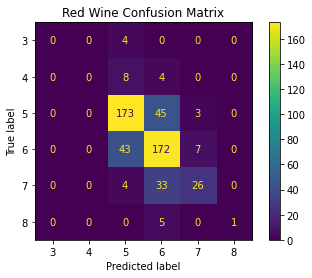

In [10]:
plot_confusion_matrix(ovr, X_test, y_test, display_labels=score)
plt.title('Red Wine Confusion Matrix')
#plt.savefig('red_confusion_matrix.png')
plt.show()